## wifi feature by kuto

[yukiさんのdataset](https://www.kaggle.com/dataset/951fe0fd675e58937311e936e941b01d517c227ce30192c8477bbe2bddeec602)をもとにを参考に、waypointを補正したwifi featureを作成する。  
trainにwifi_x, wifi_yが加わっただけ。  

v2は線形補完をtimestampを使ってやってみる(last seenは使っていないことに注意)

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import glob
import os
import sys 
sys.path.append("../")
from src.io_f import read_data_file

from scipy import interpolate

In [2]:
base_path = '..'
feature_dir = f"{base_path}/input/wifi-feature-with-timestamp"
train_files = sorted(glob.glob(os.path.join(feature_dir, '*_train.csv')))
test_files = sorted(glob.glob(os.path.join(feature_dir, '*_test.csv')))

In [3]:
output_dir = "../input/kuto_wifi_dataset_v2/"
os.makedirs(output_dir, exist_ok=True)

In [4]:
train_file = train_files[0]
train = pd.read_csv(train_file, index_col=0).reset_index(drop=True).rename(columns={'foor_str':'floor_str'})
train

,000840e5c600de293cea57f13326f273c86c3988,005246b6f51feb1a069e8f005d3e6aba2591b65b,0076ff7a084cb2ac8c146139965ab1be296e72c4,009a3ed672be7bd1b9c4437b43a53296771af098,00ad587dcb9c7ce3788b92e22777a22ee0efea31,00af060fc145ee6a6a50475efa57b91cbf54237f,00bcc61bdea4d52d050822d66952dd707c2fcdf3,00c8933965e23cd2bb890ca08ee7f8a22f933df8,00f0904087c01d922d6ebf3005607dfdeaf6687b,00f09c4561768a871af2921cffa0a4fda515766b,...,ffc7c34369257431c7de9129094deb923bb3e3af,ffe53bd4dcfaa42668baf5ea0d2ddc676538fce0,fffedf27bf3bf8fa64d01e6b0a6affc9170716f1,timestamp,x,y,f,floor_str,path,time_diff
0,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-53,-999,-999,1578462618392,230.037380,153.49635,-1,B1,5e15730aa280850006f3d005,434
1,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-53,-999,-999,1578462618392,230.037380,153.49635,-1,B1,5e15730aa280850006f3d005,2331
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-55,-999,-999,1578462618392,230.037380,153.49635,-1,B1,5e15730aa280850006f3d005,4257
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-52,-999,-999,1578462628512,231.402900,158.41515,-1,B1,5e15730aa280850006f3d005,-3938
4,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-53,-999,-999,1578462628512,231.402900,158.41515,-1,B1,5e15730aa280850006f3d005,-2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9291,-999,-999,-999,-999,-999,-75,-999,-999,-86,-999,...,-999,-78,-999,1572951934638,123.473170,77.84787,3,F4,5dc1579ebce0a000068ae8eb,3771
9292,-999,-999,-999,-999,-999,-75,-999,-999,-84,-999,...,-999,-78,-999,1572951934638,123.473170,77.84787,3,F4,5dc1579ebce0a000068ae8eb,5801
9293,-999,-999,-999,-999,-999,-72,-999,-999,-82,-999,...,-999,-78,-999,1572951946278,126.059975,68.08712,3,F4,5dc1579ebce0a000068ae8eb,-3807
9294,-999,-999,-999,-999,-999,-72,-999,-999,-79,-999,...,-999,-999,-999,1572951946278,126.059975,68.08712,3,F4,5dc1579ebce0a000068ae8eb,-1777


In [5]:
train_files

['../input/wifi-feature-with-timestamp/5a0546857ecc773753327266_timediff_1000_train.csv',
 '../input/wifi-feature-with-timestamp/5c3c44b80379370013e0fd2b_timediff_1000_train.csv',
 '../input/wifi-feature-with-timestamp/5d27075f03f801723c2e360f_timediff_1000_train.csv',
 '../input/wifi-feature-with-timestamp/5d27096c03f801723c31e5e0_timediff_1000_train.csv',
 '../input/wifi-feature-with-timestamp/5d27097f03f801723c320d97_timediff_1000_train.csv',
 '../input/wifi-feature-with-timestamp/5d27099f03f801723c32511d_timediff_1000_train.csv',
 '../input/wifi-feature-with-timestamp/5d2709a003f801723c3251bf_timediff_1000_train.csv',
 '../input/wifi-feature-with-timestamp/5d2709b303f801723c327472_timediff_1000_train.csv',
 '../input/wifi-feature-with-timestamp/5d2709bb03f801723c32852c_timediff_1000_train.csv',
 '../input/wifi-feature-with-timestamp/5d2709c303f801723c3299ee_timediff_1000_train.csv',
 '../input/wifi-feature-with-timestamp/5d2709d403f801723c32bd39_timediff_1000_train.csv',
 '../input

In [6]:
import sys 
sys.path.append("../")
from multiprocessing import Pool

def wifi_waypoint_by_linear_interpolation(
        trajectory_timestamp, wifi_timestamp,
        x_observed, y_observed, delta_time=1000,
        ): 

    wifi_waypoint_list = []
    num_interpolation = len(trajectory_timestamp) - 1  # 補完回数 
    # 各waypoint間で線形補完
    for i in range(num_interpolation):
        # 潜在的なtimestampを作成(これのどれかにwifiを当てはめるような形)
        n_split = int((max(trajectory_timestamp[i:i+2]) - min(trajectory_timestamp[i:i+2])) / delta_time) + 2  # delta_time刻みとなるように分割数を指定(+2は始点と終点分)
        timestamp_latent = np.linspace(min(trajectory_timestamp[i:i+2]), max(trajectory_timestamp[i:i+2]), n_split).astype(int) 
        
        # xが昇順の場合はlatentも昇順になるようにする
        if x_observed[i] < x_observed[i+1]:
            x_latent = np.linspace(min(x_observed[i:i+2]), max(x_observed[i:i+2]), n_split)
        # xが降順の場合はlatentも降順になるようにする
        else:
            x_latent = np.linspace(min(x_observed[i:i+2]), max(x_observed[i:i+2]), n_split)[::-1]
        
        # 線形補完関数の適用
        fitted_curve = interpolate.interp1d(x_observed[i:i+2], y_observed[i:i+2])

        # wifiのtimestampに最も近いものをsplit_timestampから取得しそれに対応するwaypointをwifiのwaypointとして取得
        wifi_x = []
        wifi_y = []

        # 区間内のwifiデータのみ考える
        if i == num_interpolation-1:
            # 最後のwaypointより未来のwifiデータがあるようなのでこの処理を追加
            target_idx = min(trajectory_timestamp[i:i+2]) <= wifi_timestamp
        else:
            target_idx = (min(trajectory_timestamp[i:i+2]) <= wifi_timestamp) & (wifi_timestamp < max(trajectory_timestamp[i:i+2]))
        target_wifi_timestamp = wifi_timestamp[target_idx]

        # timestampが最も近いものをwifiのwaypointとして取得
        for t in target_wifi_timestamp:
            idx = np.abs(timestamp_latent - t).argmin()  # wifiデータとtimestampが最も近いものをlatentから取得
            wifi_x.append(x_latent[idx])
            wifi_y.append(fitted_curve(x_latent[idx]))

        wifi_waypoint = np.stack([wifi_x, wifi_y], axis=1)
        wifi_waypoint_list.append(wifi_waypoint)

    wifi_waypoint = np.concatenate(wifi_waypoint_list)
    return wifi_waypoint

def get_wifi_waypoint(site, floor, path, timestamp):
    path_file = f'../input/indoor-location-navigation/train/{site}/{floor}/{path}.txt'
    example = read_data_file(path_file)

    # waypoint
    trajectory = example.waypoint
    trajectory_timestamp = trajectory[:,0]
    trajectory_waypoint = trajectory[:, 1:]
    x_observed = trajectory_waypoint[:, 0]
    y_observed = trajectory_waypoint[:, 1]

    # wifi
    wifi = example.wifi
    wifi_timestamp = np.unique(wifi[:, 0]).astype(int)

    # 線形補完
    wifi_waypoint = wifi_waypoint_by_linear_interpolation(trajectory_timestamp, wifi_timestamp,x_observed, y_observed) 
    return wifi_waypoint

In [7]:

def make_dataset_for_train(train_file):
    train = pd.read_csv(train_file, index_col=0).reset_index(drop=True).rename(columns={'foor_str':'floor_str'})
    file_name = train_file.split('/')[-1]
    num_of_lines = train.shape[0]
    print(f'{file_name} : {num_of_lines}')

    data_list = []
    for path, df in tqdm(train.groupby('path')):

        bssid = df.columns[:-7].values
        rssi = df.iloc[:, :-7].values
        targets = df.iloc[:,-7:].values

        # path内の各waypointのwifi値を取得
        sort_rssi = []
        sort_bssid = []
        for i in range(len(df)):
            sort_rssi.append(np.sort(rssi[i])[::-1][:100])
            idx = np.argsort(rssi[i])[::-1]
            sort_bssid.append(bssid[idx][:100])

        sort_rssi = np.stack(sort_rssi)
        sort_bssid = np.stack(sort_bssid)
        site = train_file.split('/')[-1].split('_')[0]
        timestamp = targets[i][0]
        floor = targets[i][4]
  
        wifi_waypoint = get_wifi_waypoint(site, floor, path, timestamp)  # 1行ずつ処理するのは計算コスト的にもったいない
        path_data = np.concatenate((sort_bssid, sort_rssi, targets, wifi_waypoint), axis=1)
        path_df = pd.DataFrame(path_data)
        data_list.append(path_df)
    
    data_df = pd.concat(data_list)
    columns = [f'bssid_{str(i)}' for i in range(100)] + [f'rssi_{str(i)}' for i in range(100)] + \
            ['timestamp', 'x', 'y', 'floor', 'floor_str', 'path', 'time_diff', 'wifi_x', 'wifi_y']
    data_df.columns = columns
    data_df.to_csv(output_dir + file_name, index=False)


In [8]:
with Pool(processes=24) as pool:
    pool.map(make_dataset_for_train, train_files)

5da138274db8ce0c98bbd3d2_timediff_1000_train.csv : 2662
5da138364db8ce0c98bc00f1_timediff_1000_train.csv : 2767


5da1389e4db8ce0c98bd0547_timediff_1000_train.csv : 6312


5d27099f03f801723c32511d_timediff_1000_train.csv : 4251
5d2709a003f801723c3251bf_timediff_1000_train.csv : 3940


5da138754db8ce0c98bca82f_timediff_1000_train.csv : 7188


5d27096c03f801723c31e5e0_timediff_1000_train.csv : 9100


5da138314db8ce0c98bbf3a0_timediff_1000_train.csv : 9012
5d2709e003f801723c32d896_timediff_1000_train.csv : 11042


5da138764db8ce0c98bcaa46_timediff_1000_train.csv : 9420


5d2709d403f801723c32bd39_timediff_1000_train.csv : 10027


5da1383b4db8ce0c98bc11ab_timediff_1000_train.csv : 13196


5d27097f03f801723c320d97_timediff_1000_train.csv : 10507


5d2709b303f801723c327472_timediff_1000_train.csv : 15358
5da1382d4db8ce0c98bbe92e_timediff_1000_train.csv : 8999


5c3c44b80379370013e0fd2b_timediff_1000_train.csv : 9737
5d2709bb03f801723c32852c_timediff_1000_train.csv : 17203


5a0546857ecc773753327266_timediff_1000_train.csv : 9296


5da958dd46f8266d0737457b_timediff_1000_train.csv : 15148


5dc8cea7659e181adb076a3f_timediff_1000_train.csv : 15655


5da138b74db8ce0c98bd4774_timediff_1000_train.csv : 17382


5dbc1d84c1eb61796cf7c010_timediff_1000_train.csv : 16174


5d2709c303f801723c3299ee_timediff_1000_train.csv : 10083




5d27075f03f801723c2e360f_timediff_1000_train.csv : 23666


In [15]:
def make_dataset_for_test(test_file):
    train = pd.read_csv(test_file)

    file_name = test_file.split('/')[-1]

    num_of_lines = train.shape[0]
    print(f'{file_name} : {num_of_lines}')

    data = None
    for i in tqdm(range(num_of_lines)):

        tmp = train.iloc[i,1:-2].astype(int).sort_values(ascending=False).head(100)
        target = train.iloc[i, -2:]

        line = pd.concat([pd.Series(tmp.index.astype(str)), tmp.astype(int), pd.Series(target)])
        line.index = [str(i) for i in range(202)]
        if data is None:
            data = pd.DataFrame(line).T
            data.columns = [str(i) for i in range(202)]
        else:
            data = data.append(line, ignore_index=True)
    data.columns = [f'bssid_{str(i)}' for i in range(100)] + [f'rssi_{str(i)}' for i in range(100)] + ['site_path_timestamp', 'time_diff']
    data.to_csv(output_dir + file_name, index=False)

In [17]:
with Pool(processes=24) as pool:
    pool.map(make_dataset_for_test, test_files)

5da138274db8ce0c98bbd3d2_timediff_1000_test.csv : 103
5da1389e4db8ce0c98bd0547_timediff_1000_test.csv : 1745d27099f03f801723c32511d_timediff_1000_test.csv : 49

5da138364db8ce0c98bc00f1_timediff_1000_test.csv : 139


5d2709a003f801723c3251bf_timediff_1000_test.csv : 218
5da138314db8ce0c98bbf3a0_timediff_1000_test.csv : 171


5da138754db8ce0c98bca82f_timediff_1000_test.csv : 386
5d27096c03f801723c31e5e0_timediff_1000_test.csv : 654
5d2709e003f801723c32d896_timediff_1000_test.csv : 531


5da1383b4db8ce0c98bc11ab_timediff_1000_test.csv : 380


5d27097f03f801723c320d97_timediff_1000_test.csv : 303
5da138764db8ce0c98bcaa46_timediff_1000_test.csv : 573
5c3c44b80379370013e0fd2b_timediff_1000_test.csv : 26


5d2709b303f801723c327472_timediff_1000_test.csv : 527


5da1382d4db8ce0c98bbe92e_timediff_1000_test.csv : 311


5d2709d403f801723c32bd39_timediff_1000_test.csv : 1223


5d2709bb03f801723c32852c_timediff_1000_test.csv : 716
5a0546857ecc773753327266_timediff_1000_test.csv : 299
5d27075f03f801723c2e360f_timediff_1000_test.csv : 47


5da138b74db8ce0c98bd4774_timediff_1000_test.csv : 445


5dc8cea7659e181adb076a3f_timediff_1000_test.csv : 648


5da958dd46f8266d0737457b_timediff_1000_test.csv : 778


5dbc1d84c1eb61796cf7c010_timediff_1000_test.csv : 923
5d2709c303f801723c3299ee_timediff_1000_test.csv : 509


In [19]:
import pickle
dfs = []
for f in glob.glob(output_dir + '*train.csv'):
    site_id = f.split('/')[-1].split('_')[0]
    _df = pd.read_csv(f)
    _df['site_id'] = site_id
    dfs.append(_df)

In [20]:
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
to_pickle(output_dir + 'train_all.pkl', pd.concat(dfs).reset_index(drop=True))

In [21]:
dfs = []
for f in glob.glob(output_dir + '*test.csv'):
    site_id = f.split('/')[-1].split('_')[0]
    _df = pd.read_csv(f)
    _df['site_id'] = site_id
    dfs.append(_df)

In [22]:
to_pickle(output_dir + 'test_all.pkl', pd.concat(dfs).reset_index(drop=True))

In [3]:
import os
import sys
import glob
import yaml
import pickle
from pathlib import Path
# waypointを補正したdataset
root_dir = Path('../input/')
with open(root_dir/'kuto_wifi_dataset_v2/train_all.pkl', 'rb') as f:
  train_df = pickle.load(f)

In [6]:
train_df

,bssid_0,bssid_1,bssid_2,bssid_3,bssid_4,bssid_5,bssid_6,bssid_7,bssid_8,bssid_9,...,timestamp,x,y,floor,floor_str,path,time_diff,wifi_x,wifi_y,site_id
0,ffe684dfd25a52b046e3108a3f70df46001425f0,97e4a381c3a02ed3151bbf41b8fc1fe5815f5387,5b71ef95e53358c558b78bf3fb152d793729bc8d,2f85d197aec7bfddfee3f53ae9e1b6ed1fc56e92,4328f33869766d0f77a9299441556338e4d8a2b9,df41c761b69993669d4eb875b4474ec44d2372ed,7dc49736770ee9073043134656c89a17529f882f,5a1a7a8496e5f8b88db082de0b412e447e01fd0b,463d0cfe3748eb70524138ed970f03375e8d1030,79179095e63e2b0431e85e3e33b02d95bb135c2e,...,1571625311855,68.064926,241.94000,0,F1,5dad1ca1dc3e2c0006606c3f,1952,66.823935,241.889369,5da958dd46f8266d0737457b
1,97e4a381c3a02ed3151bbf41b8fc1fe5815f5387,5b71ef95e53358c558b78bf3fb152d793729bc8d,cb8f53745c342e2bfd0bf77a5fd8cac6cf303945,ffe684dfd25a52b046e3108a3f70df46001425f0,6b769b9eeb24ff287e6a53736cc7c013d5902901,7dc49736770ee9073043134656c89a17529f882f,3fef087dd272ab07981a60c9cbf6f27460d1364e,5a1a7a8496e5f8b88db082de0b412e447e01fd0b,df41c761b69993669d4eb875b4474ec44d2372ed,d8b1ff62702e02106553be91dc22a0dcf0e780a7,...,1571625311855,68.064926,241.94000,0,F1,5dad1ca1dc3e2c0006606c3f,3900,65.582943,241.838738,5da958dd46f8266d0737457b
2,97e4a381c3a02ed3151bbf41b8fc1fe5815f5387,6b769b9eeb24ff287e6a53736cc7c013d5902901,cb8f53745c342e2bfd0bf77a5fd8cac6cf303945,4328f33869766d0f77a9299441556338e4d8a2b9,3fef087dd272ab07981a60c9cbf6f27460d1364e,5a1a7a8496e5f8b88db082de0b412e447e01fd0b,7dc49736770ee9073043134656c89a17529f882f,df41c761b69993669d4eb875b4474ec44d2372ed,5b71ef95e53358c558b78bf3fb152d793729bc8d,2f85d197aec7bfddfee3f53ae9e1b6ed1fc56e92,...,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,-2385,64.341952,241.788107,5da958dd46f8266d0737457b
3,97e4a381c3a02ed3151bbf41b8fc1fe5815f5387,4328f33869766d0f77a9299441556338e4d8a2b9,3fef087dd272ab07981a60c9cbf6f27460d1364e,5a1a7a8496e5f8b88db082de0b412e447e01fd0b,5d82171d37c5296bcaed8c02745540b491d8a284,471740ef5065943b791f277ada358f9ffc011645,2f85d197aec7bfddfee3f53ae9e1b6ed1fc56e92,afe423c7bc0641d63c95e232ffd65cae3be95351,df41c761b69993669d4eb875b4474ec44d2372ed,5b71ef95e53358c558b78bf3fb152d793729bc8d,...,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,-427,62.480465,241.712160,5da958dd46f8266d0737457b
4,97e4a381c3a02ed3151bbf41b8fc1fe5815f5387,4328f33869766d0f77a9299441556338e4d8a2b9,5a1a7a8496e5f8b88db082de0b412e447e01fd0b,cb8f53745c342e2bfd0bf77a5fd8cac6cf303945,6b769b9eeb24ff287e6a53736cc7c013d5902901,5d82171d37c5296bcaed8c02745540b491d8a284,5b71ef95e53358c558b78bf3fb152d793729bc8d,df41c761b69993669d4eb875b4474ec44d2372ed,2f85d197aec7bfddfee3f53ae9e1b6ed1fc56e92,afe423c7bc0641d63c95e232ffd65cae3be95351,...,1571625320099,62.480465,241.71216,0,F1,5dad1ca1dc3e2c0006606c3f,1528,62.893219,240.715162,5da958dd46f8266d0737457b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258120,993a56b32432fb19bfb4461a0e1a2ead9bcf192f,773cde25cb4e9fd90b11603abd5bf84d83b340e6,19647ac7bb55a673554aa08cafb3b096aac7f32c,a4a410696cb935d542d62afd8e8090dbbc341a16,fc27c0656fc13157bb2f58543d51e8ee972fdf66,c7d8359344120911f8550487f282c241d93c4750,26b22cce3b7694a7d765d9cf329b9065f3fb3a3c,827530050f580378b7aa53fb292dfb8a12b775e1,d64eeb8d997e8d87203479556bbb9efaf7e487fd,22a52f1717436ee378dc44b6d707a3816a65b5e4,...,1573822164854,12.662716,100.47756,1,F2,5dce9eea5516ad00065f04a7,447,12.662716,100.477560,5d27099f03f801723c32511d
258121,773cde25cb4e9fd90b11603abd5bf84d83b340e6,993a56b32432fb19bfb4461a0e1a2ead9bcf192f,19647ac7bb55a673554aa08cafb3b096aac7f32c,fc27c0656fc13157bb2f58543d51e8ee972fdf66,a4a410696cb935d542d62afd8e8090dbbc341a16,827530050f580378b7aa53fb292dfb8a12b775e1,c7d8359344120911f8550487f282c241d93c4750,d64eeb8d997e8d87203479556bbb9efaf7e487fd,b08a1d79d6d4bb2ca71336f7e995c7aa1342aa1f,26b22cce3b7694a7d765d9cf329b9065f3fb3a3c,...,1573822164854,12.662716,100.47756,1,F2,5dce9eea5516ad00065f04a7,2393,11.041773,102.698110,5d27099f03f801723c32511d
258122,993a56b32432fb19bfb4461a0e

<AxesSubplot:>

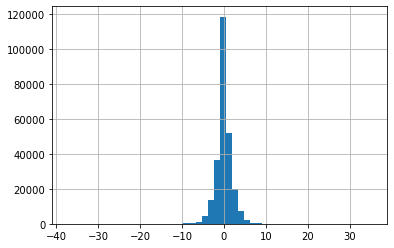

In [11]:
(train_df['x'] - train_df['wifi_x']).hist(bins=50)

<AxesSubplot:>

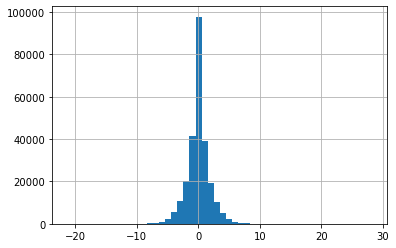

In [12]:
(train_df['y'] - train_df['wifi_y']).hist(bins=50)

In [15]:
print((train_df['x'] - train_df['wifi_x']).std())
print((train_df['y'] - train_df['wifi_y']).std())

1.9266937226098104
1.8650742693762432
